## Trial to use Convolutional Neural Network (with Tensorflow) to detect variogram plot that implies stationary time series

### Load and preprocess plot images

#### Based on tutorial: https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.9.1'

##### In order to get the format of data_dir (from example)

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

In [5]:
data_dir

'/Users/tadatoshi/.keras/datasets/flower_photos'

##### So, it's just a string with absolute path

In [6]:
os.path.realpath('.')

'/Users/tadatoshi/Documents/development/projects/tadatoshi_solar_research_society/time_series_plot_auto_analysis/notebooks'

##### It seems that image label is based on the directory name that contains images. 
##### Thus, I will create two directory, "stationary" and "nonstationary" and place the corresponding plots under them manually. 

In [7]:
plots_data_dir = os.path.abspath(os.path.join(os.path.realpath('.'), '../plots/synthetic_variograms'))

In [8]:
plots_data_dir

'/Users/tadatoshi/Documents/development/projects/tadatoshi_solar_research_society/time_series_plot_auto_analysis/plots/synthetic_variograms'

##### Get image size

##### Based on https://note.nkmk.me/en/python-opencv-pillow-image-size/

In [9]:
import cv2

In [10]:
image_1 = cv2.imread(os.path.join(plots_data_dir, 'stationary/synthetic_variogram_20220629150855_3.png'))

In [11]:
type(image_1)

numpy.ndarray

In [12]:
image_1.shape

(288, 432, 3)

### Create a dataset

In [13]:
batch_size = 32
img_height = 288
img_width = 432

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  plots_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 80 files for training.


2022-07-01 12:57:33.194385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  plots_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 20 files for validation.


In [16]:
class_names = train_ds.class_names
class_names

['nonstationary', 'stationary']

### Visualize the data

#### First 9 images from the training dataset

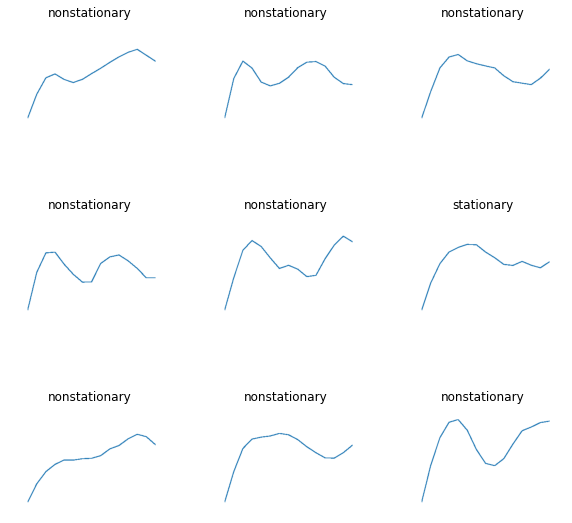

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 288, 432, 3)
(32,)


### Configure the dataset for performance

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

#### Try with the same layers as the tutorial even though I am not sure if it's too much for the simple images of plots.

In [20]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [22]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
3/3 [==============================] - 9s 2s/step - loss: 4.2121 - accuracy: 0.5250 - val_loss: 2.6780 - val_accuracy: 0.5000
Epoch 2/3
3/3 [==============================] - 7s 2s/step - loss: 1.2784 - accuracy: 0.4750 - val_loss: 0.9314 - val_accuracy: 0.5000
Epoch 3/3
3/3 [==============================] - 7s 2s/step - loss: 0.7139 - accuracy: 0.7000 - val_loss: 0.7271 - val_accuracy: 0.5000


#### The tutorial goes on for custom data loading for better performance. 
#### But what has been done is sufficient for the porpose, so continue on prediction. 

#### Back to following Image Classificaton tutorial https://www.tensorflow.org/tutorials/images/classification

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 288, 432, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 106, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 104, 32)       9

### Visualize training results

In [25]:
model.history

Text(0.5, 1.0, 'Training and Validation Loss')

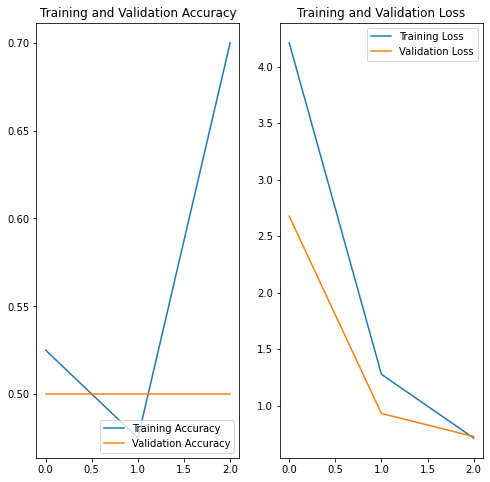

In [27]:
epochs=3

acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

### Predict on new data

In [30]:
new_stationary_plot_1_path = os.path.join(plots_data_dir, 
                                     'new_data_for_prediction/stationary/synthetic_variogram_20220701133525_2.png')

new_stationary_plot_1 = tf.keras.utils.load_img(
    new_stationary_plot_1_path, target_size=(img_height, img_width)
)

(-0.5, 431.5, 287.5, -0.5)

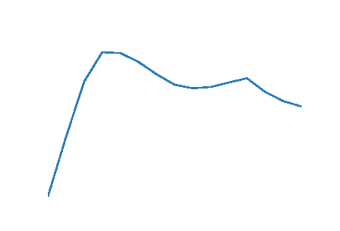

In [32]:
plt.imshow(new_stationary_plot_1)
plt.axis('off')

In [34]:
new_stationary_plot_array_1 = tf.keras.utils.img_to_array(new_stationary_plot_1)

In [36]:
type(new_stationary_plot_array_1)

numpy.ndarray

In [37]:
new_stationary_plot_array_1.shape

(288, 432, 3)

In [38]:
new_stationary_plot_array_1 = tf.expand_dims(new_stationary_plot_array_1, 0) # Create a batch

In [40]:
new_stationary_plot_array_1.shape

TensorShape([1, 288, 432, 3])

In [39]:
new_stationary_plot_array_1_predictions = model.predict(new_stationary_plot_array_1)

1/1 [==============================] - 0s 177ms/step


In [41]:
new_stationary_plot_array_1_predictions.shape

(1, 2)

In [42]:
new_stationary_plot_array_1_predictions

array([[ 0.4271328, -0.11301  ]], dtype=float32)

In [45]:
new_stationary_plot_array_1_score = tf.nn.softmax(new_stationary_plot_array_1_predictions[0])

In [46]:
new_stationary_plot_array_1_score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6318456 , 0.36815438], dtype=float32)>

In [60]:
f"This image most likely belongs to {class_names[np.argmax(new_stationary_plot_array_1_score)]} with a {100 * np.max(new_stationary_plot_array_1_score):.2f} percent confidence."

'This image most likely belongs to nonstationary with a 63.18 percent confidence.'

##### Incorrect prediction but the confidence is low as well.

#### Another new data

In [48]:
new_stationary_plot_2_path = os.path.join(plots_data_dir, 
                                     'new_data_for_prediction/stationary/synthetic_variogram_20220701133525_3.png')

new_stationary_plot_2 = tf.keras.utils.load_img(
    new_stationary_plot_2_path, target_size=(img_height, img_width)
)

(-0.5, 431.5, 287.5, -0.5)

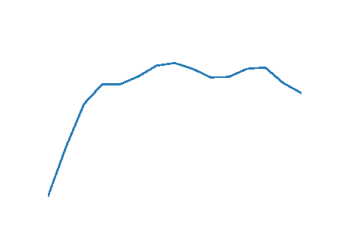

In [49]:
plt.imshow(new_stationary_plot_2)
plt.axis('off')

In [50]:
new_stationary_plot_array_2 = tf.keras.utils.img_to_array(new_stationary_plot_2)

In [51]:
new_stationary_plot_array_2 = tf.expand_dims(new_stationary_plot_array_2, 0) # Create a batch

In [52]:
new_stationary_plot_array_2_predictions = model.predict(new_stationary_plot_array_2)

1/1 [==============================] - 0s 77ms/step


In [53]:
new_stationary_plot_array_2_predictions

array([[ 0.41354033, -0.10821091]], dtype=float32)

In [54]:
new_stationary_plot_array_2_score = tf.nn.softmax(new_stationary_plot_array_2_predictions[0])

In [55]:
new_stationary_plot_array_2_score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.62755716, 0.37244284], dtype=float32)>

In [59]:
f"This image most likely belongs to {class_names[np.argmax(new_stationary_plot_array_2_score)]} with a {100 * np.max(new_stationary_plot_array_2_score):.2f} percent confidence."

'This image most likely belongs to nonstationary with a 62.76 percent confidence.'

##### Again, incorrect prediction with low confidence.

### Try more epochs to see if that increases accuracy

In [62]:
model_2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [63]:
model_2.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [64]:
model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 2.3770 - accuracy: 0.6750 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 0.7374 - accuracy: 0.3000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.6754 - accuracy: 0.7000 - val_loss: 0.7505 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.6232 - accuracy: 0.7000 - val_loss: 0.7836 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 8s 2s/step - loss: 0.6108 - accuracy: 0.7000 - val_loss: 0.7547 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.6066 - accuracy: 0.7000 - val_loss: 0.7177 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 8s 2s/step - loss: 0.6199 - accuracy: 0.7000 - val_loss: 0.7293 - val_accuracy: 0.5000
Epoch 8/10
3/3 [=========================

#### Accuracy stays at 0.7000 after epoch 3. 

### Try model with Conv2D layers with increasing number of parameters

In [67]:
model_3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [68]:
model_3.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [69]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 288, 432, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 286, 430, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 143, 215, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 141, 213, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 70, 106, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 68, 104, 64)      

In [70]:
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 5.8928 - accuracy: 0.5250 - val_loss: 3.1328 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 1.5568 - accuracy: 0.4500 - val_loss: 0.7136 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.6795 - accuracy: 0.7000 - val_loss: 0.8433 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.6105 - accuracy: 0.7000 - val_loss: 0.7042 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.6487 - accuracy: 0.7000 - val_loss: 0.7197 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.6322 - accuracy: 0.7000 - val_loss: 0.7404 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.6055 - accuracy: 0.7000 - val_loss: 0.7397 - val_accuracy: 0.5000
Epoch 8/10
3/3 [=========================

#### Accuracy stays at 0.7000 after epoch 3 again.

### Try simplified model

In [71]:
model_4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [72]:
model_4.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [73]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 288, 432, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 143, 215, 32)     0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 983840)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               125931648 
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                      

In [74]:
history = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 132.4144 - accuracy: 0.5250 - val_loss: 210.8280 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 55.9207 - accuracy: 0.7250 - val_loss: 6.4748 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 5.4557 - accuracy: 0.2750 - val_loss: 0.7891 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 0.6536 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 4.4902 - accuracy: 0.3000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.6930 - accuracy: 0.7000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.6926 - accuracy: 0.7000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
3/3 [====================

#### Accuracy stayed at 0.7000 after epoch 5.

Text(0.5, 1.0, 'Training and Validation Loss')

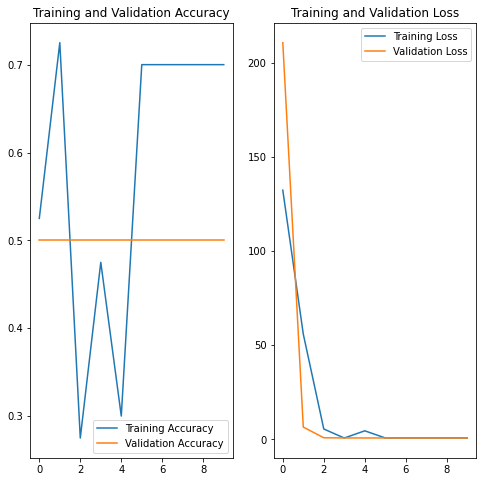

In [75]:
acc_4 = model_4.history.history['accuracy']
val_acc_4 = model_4.history.history['val_accuracy']

loss_4 = model_4.history.history['loss']
val_loss_4 = model_4.history.history['val_loss']

epochs_range_4 = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_4, acc_4, label='Training Accuracy')
plt.plot(epochs_range_4, val_acc_4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_4, loss_4, label='Training Loss')
plt.plot(epochs_range_4, val_loss_4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

### Try prediction with the last model

In [77]:
new_stationary_plot_array_4_1_predictions = model_4.predict(new_stationary_plot_array_1)

1/1 [==============================] - 0s 146ms/step


In [78]:
new_stationary_plot_array_4_1_score = tf.nn.softmax(new_stationary_plot_array_4_1_predictions[0])

In [79]:
new_stationary_plot_array_4_1_score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.503174, 0.496826], dtype=float32)>

In [80]:
f"This image most likely belongs to {class_names[np.argmax(new_stationary_plot_array_4_1_score)]} with a {100 * np.max(new_stationary_plot_array_4_1_score):.2f} percent confidence."

'This image most likely belongs to nonstationary with a 50.32 percent confidence.'

##### Incorrect prediction with about 50% of confidence

In [81]:
new_stationary_plot_array_4_2_predictions = model_4.predict(new_stationary_plot_array_2)

1/1 [==============================] - 0s 113ms/step


In [82]:
new_stationary_plot_array_4_2_score = tf.nn.softmax(new_stationary_plot_array_4_2_predictions[0])

In [83]:
new_stationary_plot_array_4_2_score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.503174, 0.496826], dtype=float32)>

In [84]:
f"This image most likely belongs to {class_names[np.argmax(new_stationary_plot_array_4_2_score)]} with a {100 * np.max(new_stationary_plot_array_4_2_score):.2f} percent confidence."

'This image most likely belongs to nonstationary with a 50.32 percent confidence.'

##### Incorrect prediction with about 50% of confidence